In [1]:
import pandas as pd
from igraph import Graph
import igraph
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np
import pickle
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, models, Model
import time
from collections import defaultdict
from IPython.display import display, HTML
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing, model_selection
import warnings

warnings.filterwarnings(action='ignore')

/home/jhpark/anaconda3/envs/jeongha/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
dataset = sg.datasets.CiteSeer()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)
        Features: none


In [4]:
# Convert the data structure from StellarGraph -> NetworkX -> Igraph
ig = Graph.from_networkx(G.to_networkx())

In [5]:
multi = Graph.community_multilevel(ig)
print(multi.summary())
label = Graph.community_label_propagation(ig)
print(label.summary())

Clustering with 3312 elements and 468 clusters
Clustering with 3312 elements and 661 clusters


In [6]:
cd_algo = multi
fea_mat = pd.DataFrame(G.node_features(),index= G.nodes())

In [ ]:
size_thresh = 100
minor_nodes_num = 0
major_comm_num = 0
minor_nodes_id = []
minor_nodes_features = []
for i in cd_algo:
    if len(i) < size_thresh: 
        minor_nodes_num += len(i)
        minor_nodes_id.extend(i)
        for n in i: 
            minor_nodes_features.append(ig.vs['_nx_name'][n])
    else:
        major_comm_num += 1
print("The number of nodes in minor communities: ", minor_nodes_num)
print("The number of major communities: ", major_comm_num)
print("The number of nodes in CaaN graph: ",major_comm_num+minor_nodes_num)

In [8]:
for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) >= size_thresh: # If major community
        for node in cd_algo[commu]: # for each node 
            super_node_id[commu].append(node) # the index of nodes which should be converted to super node
            for edges in original_edges: # check edges
                if edges[0] == node: # If it includes current node
                    super_node_edges[commu].add(edges[1]) # add the neighborhood node index number
                elif edges[1] == node: 
                    super_node_edges[commu].add(edges[0])

In [9]:
# create a mapping dictionary (node id: nx_name) from igraph.
node_dict = {}
for idx in range(ig.vcount()):
    node_dict[idx] = ig.vs['_nx_name'][idx]

In [10]:
# CaaN Graph Construction
CaaN = ig.copy()
membership = cd_algo.membership
counter = Counter(membership).most_common()

minor_commuID = []
# If the community size is less than threshold, add to minor community ID list
for c in counter:
    if c[1] < size_thresh:
        minor_commuID.append(c[0])

# Re-assign membership for minor community nodes
new_id = len(cd_algo)
for i in range(len(membership)):
    if membership[i] in minor_commuID:
        membership[i] = new_id
        new_id += 1
        
idx_map = {}
n = 0
for i in sorted(dict(Counter(membership))):
    idx_map[i] = n
    n+=1
    
# Initialization by index
new_idx = 0
for i in range(len(membership)):
    membership[i] = idx_map[membership[i]]

CaaN.contract_vertices(membership, combine_attrs="first")
CaaN.simplify(combine_edges="ignore") 
print(CaaN.summary())

IGRAPH U--- 2256 2501 -- 
+ attr: _nx_name (v), feature (v), label (v)


In [11]:
# Remove minor nodes from CaaN except for super nodes
superG = CaaN.copy()
cnt = 0
deleted = []
for v in range(superG.vcount()):
    if superG.vs['_nx_name'][v] in minor_nodes_features:
        deleted.append(v)
        cnt += 1
print(cnt)
superG.delete_vertices(deleted)

2250


In [12]:
def trainGCN(G, node_subjects):
    start = time.time()
    # Data Split
    train_subjects, test_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.1, test_size=None #, stratify=node_subjects
    )
    val_subjects, test_subjects = model_selection.train_test_split(
        test_subjects, train_size=0.2, test_size=None #, stratify=test_subjects
    )
    # Converting to numeric arrays
    target_encoding = preprocessing.LabelBinarizer()
    train_targets = target_encoding.fit_transform(train_subjects)
    val_targets = target_encoding.transform(val_subjects)
    test_targets = target_encoding.transform(test_subjects)

    # Data Generator for GCN
    generator = FullBatchNodeGenerator(G, method="gcn")
    train_gen = generator.flow(train_subjects.index, train_targets)
    gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
    )

    x_inp, x_out = gcn.in_out_tensors()
    predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    
    # Train model
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )

    val_gen = generator.flow(val_subjects.index, val_targets)
    es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

    history = model.fit(
        train_gen,
        epochs=200,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
        callbacks=[es_callback],
    )
    sg.utils.plot_history(history)
    test_gen = generator.flow(test_subjects.index, test_targets)
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
    
    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    embedding_model = Model(inputs=x_inp, outputs=x_out)
    emb = embedding_model.predict(all_gen)
    print("GCN Training time: ",time.time() - start)
    return emb.squeeze(0), history.history # Return Node Embeddings, shape = (number of nodes * embedding dim)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 98ms/step - loss: 1.2408 - acc: 0.6897

Test Set Metrics:
	loss: 1.2408
	acc: 0.6897
GCN Training time:  20.36750364303589


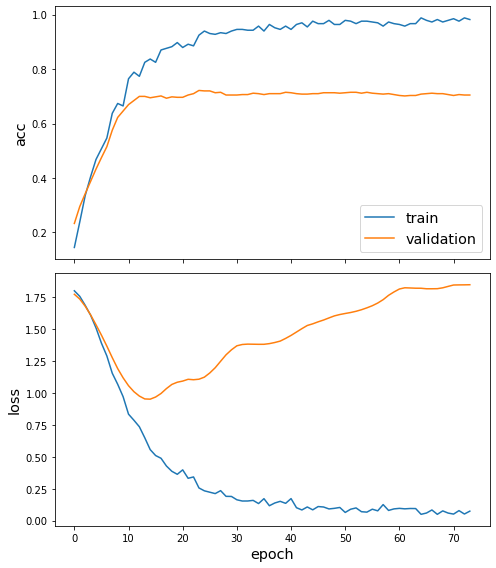

In [13]:
# Training GCN
X, base_history = trainGCN(G, node_subjects)
target_encoding = preprocessing.LabelBinarizer()
y = target_encoding.fit_transform(node_subjects)
labels = len(node_subjects.value_counts())

In [62]:
base_hist_loss = CaaN_history['loss'][:50]

In [63]:
CaaN_hist_loss = base_history['loss'][:50]

In [25]:
CaaN_hist_acc = base_history['acc'][:50]
CaaN_hist_loss = base_history['loss'][:50]
base_hist_acc = CaaN_history['acc'][:50]
base_hist_loss = CaaN_history['loss'][:50]

In [81]:
import pickle
with open('GCN_CaaN_hist_acc.pickle', 'wb') as f:
    pickle.dump(CaaN_hist_acc, f, pickle.HIGHEST_PROTOCOL)
with open('GCN_CaaN_hist_loss.pickle', 'wb') as f:
    pickle.dump(CaaN_hist_loss, f, pickle.HIGHEST_PROTOCOL)
with open('GCN_base_hist_acc.pickle', 'wb') as f:
    pickle.dump(base_hist_acc, f, pickle.HIGHEST_PROTOCOL)
with open('GCN_base_hist_loss.pickle', 'wb') as f:
    pickle.dump(base_hist_loss, f, pickle.HIGHEST_PROTOCOL)

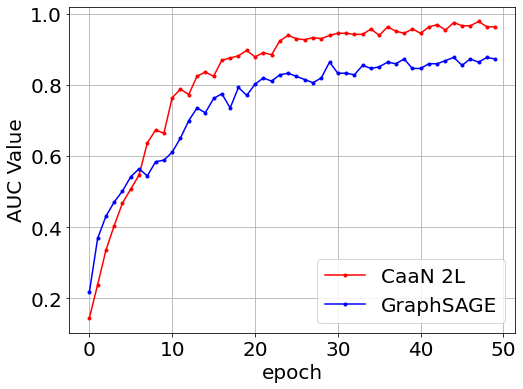

In [85]:
x_len = np.arange(len(CaaN_hist_acc))
plt.figure(figsize=(8,6))
plt.plot(x_len, CaaN_hist_acc, marker='.', c='red', label="CaaN 2L")
plt.plot(x_len, base_hist_acc, marker='.', c='blue', label="GraphSAGE")

plt.legend(loc='lower right', fontsize=20)
plt.grid()
plt.xlabel('epoch',fontsize=20)
plt.ylabel('AUC Value',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

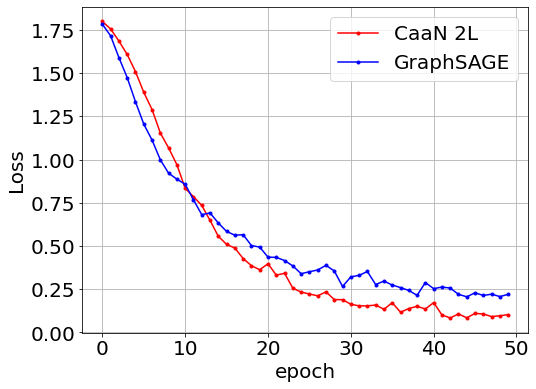

In [84]:
x_len = np.arange(len(CaaN_hist_acc))
plt.figure(figsize=(8,6))
plt.plot(x_len, CaaN_hist_loss, marker='.', c='red', label="CaaN 2L")
plt.plot(x_len, base_hist_loss, marker='.', c='blue', label="GraphSAGE")

plt.legend(loc='upper right', fontsize=20)
plt.grid()
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [16]:
# Node Embedding Test
def evaluateEmb(X,y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

    model_emb = models.Sequential()
    model_emb.add(layers.Dense(labels, activation='softmax', input_shape=(16,)))
    model_emb.compile(optimizers.Adam(learning_rate=0.01), 
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

    start = time.time()
    history = model_emb.fit(X_train,
                        y_train,
                        epochs=50,
                        shuffle=False,
                        batch_size=128)
    print(time.time() - start)

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model_emb.evaluate(X_test, y_test, batch_size=128)
    print("test loss, test acc:", results)

    sg.utils.plot_history(history)

Epoch 1/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7610 - accuracy: 0.4284
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 1.0275 - accuracy: 0.6756
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8833 - accuracy: 0.7114
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8558 - accuracy: 0.7157
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.7204
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8392 - accuracy: 0.7252
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8350 - accuracy: 0.7256
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8319 - accuracy: 0.7282
Epoch 9/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8295 - accuracy: 0.7286
Epoch 10/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8276 - accuracy: 0.7312
Epoch 11/50
19/19 [

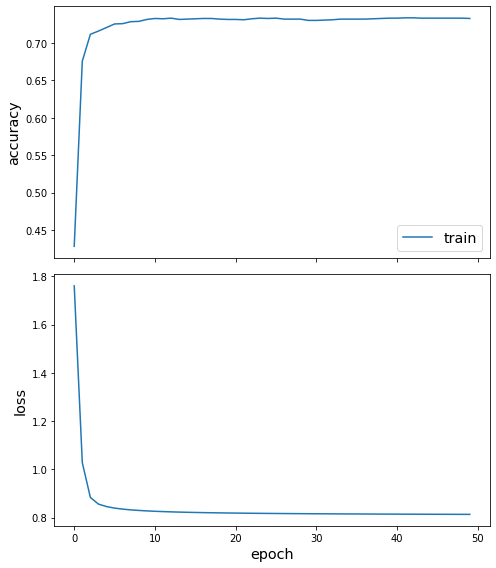

In [17]:
evaluateEmb(X,y)

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for CiteSeer dataset')]

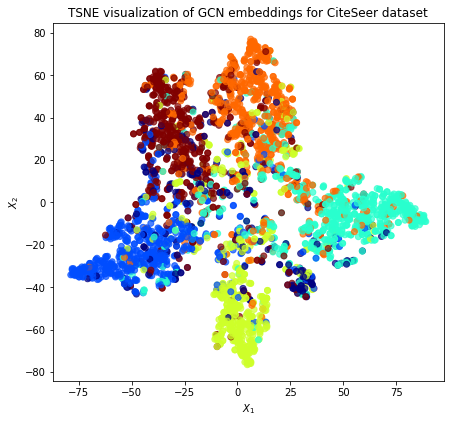

In [18]:
from sklearn.manifold import TSNE
transform = TSNE  # or PCA
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for CiteSeer dataset",
)

In [ ]:
start = time.time()
count = 0
node_embeddings = X 

# Local GRL 
for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) >= size_thresh: # Major Community
        subgraph = ig.induced_subgraph(cd_algo[commu],implementation="create_from_scratch")
        subgraph_fea_mat = fea_mat[fea_mat.index.isin(subgraph.vs['_nx_name'])] # Extract the features of subgraph
        # Type casting
        subgraph_sg = sg.StellarGraph.from_networkx(subgraph.to_networkx(), node_features = subgraph_fea_mat.reset_index(drop=True))
        subnode_subjects = node_subjects[node_subjects.index.isin(subgraph.vs['_nx_name'])].reset_index(drop=True) # Extract the labels of subgraph

        X_subgraph = trainGCN(subgraph_sg, subnode_subjects) # Local GRL 
        
        sub_node = 0
        for i in cd_algo[commu]:
            node_embeddings[i] = X_subgraph[sub_node]
            sub_node += 1
            count += 1 
        print(sub_node)

print("Overwrite : ",count)
print("Local GRL Time : ",time.time() - start)

Epoch 1/50
19/19 [==============================] - 0s 2ms/step - loss: 1.9201 - accuracy: 0.3434
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 1.1608 - accuracy: 0.6122
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 0.9607 - accuracy: 0.6941
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8999 - accuracy: 0.7118
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8736 - accuracy: 0.7174
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8600 - accuracy: 0.7222
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8516 - accuracy: 0.7222
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8456 - accuracy: 0.7243
Epoch 9/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8413 - accuracy: 0.7256
Epoch 10/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8379 - accuracy: 0.7265
Epoch 11/50
19/19 [

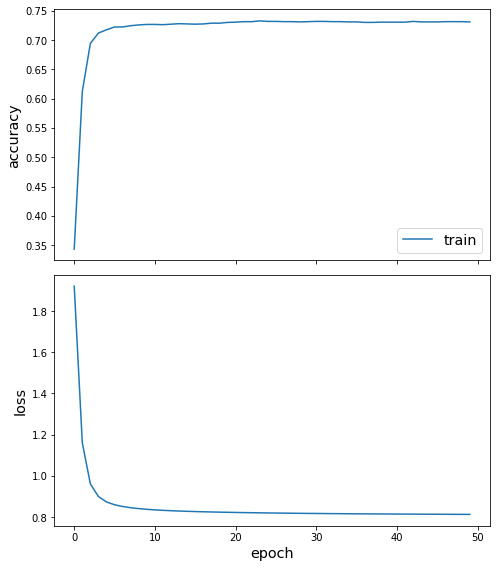

In [20]:
evaluateEmb(node_embeddings,y) 

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 68ms/step - loss: 1.2222 - acc: 0.6363

Test Set Metrics:
	loss: 1.2222
	acc: 0.6363
GCN Training time:  11.7738196849823


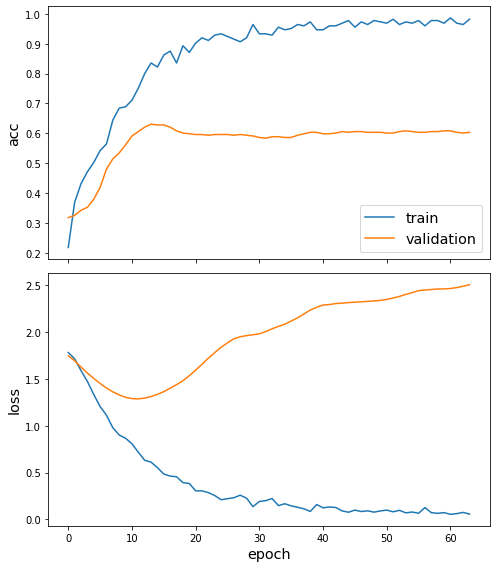

In [21]:
CaaN_fea_mat = fea_mat[fea_mat.index.isin(CaaN.vs['_nx_name'])] # subgraph들의 feature 추출

CaaN_sg = sg.StellarGraph.from_networkx(CaaN.to_networkx(), node_features = CaaN_fea_mat.reset_index(drop=True))
CaaN_subjects = node_subjects[node_subjects.index.isin(CaaN.vs['_nx_name'])].reset_index(drop=True) # subgraph들의 라벨

X_CaaN, CaaN_history = trainGCN(CaaN_sg, CaaN_subjects) # Global GRL 

In [21]:
# Global GRL
node_embeddings_v3 = node_embeddings
count = 0
for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) < size_thresh: # Minor Community
        minor_node = 0
        for i in cd_algo[commu]:
            node_embeddings_v3[i] = X_CaaN[minor_node]
            minor_node += 1
            count += 1 
print(count)

2286


Epoch 1/50
19/19 [==============================] - 0s 2ms/step - loss: 2.0560 - accuracy: 0.2209
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7923 - accuracy: 0.2373
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7573 - accuracy: 0.2575
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7343 - accuracy: 0.2705
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7241 - accuracy: 0.2692
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7158 - accuracy: 0.2696
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7089 - accuracy: 0.2731
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 1.7036 - accuracy: 0.2752
Epoch 9/50
19/19 [==============================] - 0s 2ms/step - loss: 1.6991 - accuracy: 0.2778
Epoch 10/50
19/19 [==============================] - 0s 2ms/step - loss: 1.6953 - accuracy: 0.2826
Epoch 11/50
19/19 [

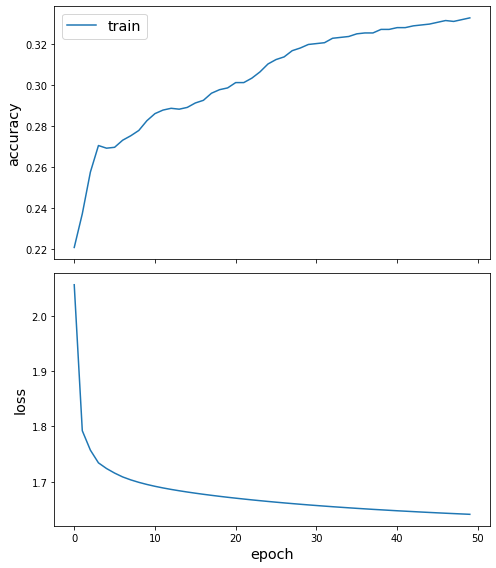

In [22]:
evaluateEmb(node_embeddings_v3, y) 

In [61]:
ig_withSuper = ig.copy() # One-level: Original graph + super node
for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) >= size_thresh: # Major Community
        super_idx = ig_withSuper.vcount()
        ig_withSuper.add_vertices(1) # add a super node
        ig_withSuper.vs[super_idx]['_nx_name'] = 'super-node'
        ig_withSuper.vs[super_idx]['label'] = 'paper'
        ig_withSuper.vs[super_idx]['feature'] = np.array([1.0]*3703)
        es = []
        for no in super_node_edges[commu]: # all nodes connected to supernode
            es.append((super_idx, no))
        ig_withSuper.add_edges(es)
print(ig_withSuper.summary())

igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3312, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3313, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3314, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3315, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3316, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
igraph.Vertex(<igraph.Graph object at 0x7fccd81495e8>, 3317, {'_nx_name': 'super-node', 'label': 'paper', 'feature': array([1., 1., 1., ..., 1., 1., 1.])})
IGRAPH U-W- 3318 5991 -- 
+ attr: _nx_name (v), feature (v), lab

In [76]:
# Node Embedding Test
ig_withSuper_fea_mat = fea_mat[fea_mat.index.isin(ig_withSuper.vs['_nx_name'])]

super = 0
for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) >= size_thresh: # Major Community
        subgraph = ig.induced_subgraph(cd_algo[commu],implementation="create_from_scratch")
        subgraph_fea_mat = fea_mat[fea_mat.index.isin(subgraph.vs['_nx_name'])]
        ig_withSuper_fea_mat.loc[len(ig_withSuper_fea_mat)] = subgraph_fea_mat.sum(axis = 0)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 101ms/step - loss: 1.2166 - acc: 0.6742

Test Set Metrics:
	loss: 1.2166
	acc: 0.6742
GCN Training time:  16.47307562828064
Epoch 1/50
19/19 [==============================] - 0s 2ms/step - loss: 2.0838 - accuracy: 0.3093
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 1.3948 - accuracy: 0.4814
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 1.2140 - accuracy: 0.6717
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 1.1601 - accuracy: 0.6829
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 1.1305 - accuracy: 0.6933
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 1.1107 - accuracy: 0.6967
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 1.0962 - accuracy: 0.6980
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 1.0846 - accuracy: 0.7006
Epoch 9/50
19

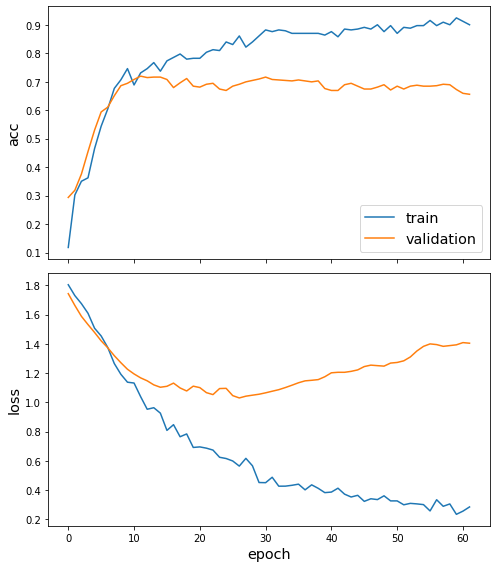

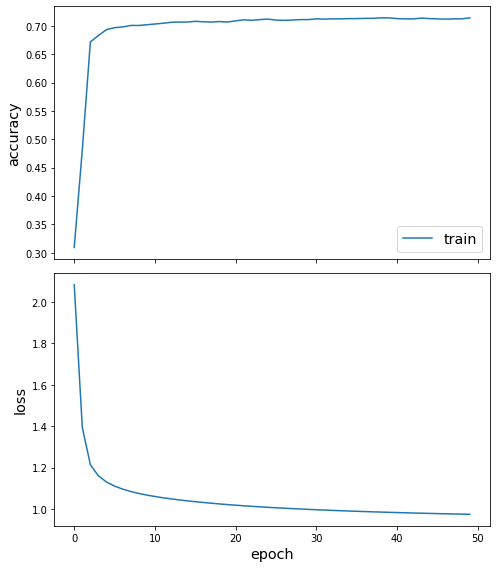

In [79]:
ig_withSuper_sg = sg.StellarGraph.from_networkx(ig_withSuper.to_networkx(), node_features = ig_withSuper_fea_mat.reset_index(drop=True))
ig_withSuper_subjects = node_subjects[node_subjects.index.isin(ig_withSuper.vs['_nx_name'])].reset_index(drop=True) 

X_ig_withSuper = trainGCN(ig_withSuper_sg, ig_withSuper_subjects) # Global GRL 
evaluateEmb(X_ig_withSuper, y) # One-level 

In [ ]:
start = time.time()
count = 0
node_embeddings = X 

for commu in range(len(cd_algo)):
    if len(cd_algo[commu]) >= size_thresh: # Major Community
        subgraph = ig.induced_subgraph(cd_algo[commu],implementation="create_from_scratch")
        super_idx = subgraph.vcount()
        subgraph.add_vertices(1) # Super node
     #   subgraph.vs[super_idx]['_nx_name']
        es = []
        for no in super_node_edges[commu]:
            es.append((super_idx, no))
        subgraph.add_edges(es)

        subgraph_fea_mat = fea_mat[fea_mat.index.isin(subgraph.vs['_nx_name'])] 
        # Type casting
        subgraph_sg = sg.StellarGraph.from_networkx(subgraph.to_networkx(), node_features = subgraph_fea_mat.reset_index(drop=True))
        subnode_subjects = node_subjects[node_subjects.index.isin(subgraph.vs['_nx_name'])].reset_index(drop=True) 

        X_subgraph = trainGCN(subgraph_sg, subnode_subjects)
        
        sub_node = 0
        for i in cd_algo[commu]:
            node_embeddings[i] = X_subgraph[sub_node]
            sub_node += 1
            count += 1 
        print(sub_node)

print("Overwrite : ",count)
print("Improved Local GRL Time : ",time.time() - start)